<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/main/%C3%9Cbung_RNN_L%C3%B6sung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung RNN

## In dieser Übung ...
... werden wir ein bisschen lyrisch. Am Ende werden Sie vielleicht noch der nächste Shakespear






In [1]:
import tensorflow as tf
import keras
import spacy
import numpy as np
import sys
print("Keras Version:", keras.__version__, "; Tensorflow version:", tf.__version__, "; spacy version:", spacy.__version__, "; NumPy version:", np.__version__, "Python version:", ".".join(str(x) for x in sys.version_info[:3]))


import matplotlib.pyplot as plt
from spacy.lang.en import English
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
import time

Keras Version: 2.4.3 ; Tensorflow version: 2.3.0 ; spacy version: 3.0.6 ; NumPy version: 1.18.5 Python version: 3.6.9


In [2]:
def generate_heading(title):
    title = str(title).upper()
    return "\n".join((f"--{title}--", "_" * (len(title) + 4)))

In [3]:
def save_book(idx, title, text):
    open(f"./{idx} - {title}.txt", 'wb').write(("\n\n\n\n".join((generate_heading(title), text))).encode("utf-8"))

In [4]:
def clean_book(txt):
    started = False
    after_page = False
    ret_txt = []
    for line in txt.split("\n"):
        if started:
            if after_page:
                if len(line.strip()) == 0:
                    pass
                else:
                    after_page = False
                    ret_txt.append(line)
            else:
                if line.startswith("Page | ") or line.strip() == "*":
                    after_page = True
                else:
                    ret_txt.append(line)
        else:
            if line.startswith("/") or line.startswith("I"):
                started = True
    return ("\n".join(ret_txt)).strip()

## x.1 Erstellen und Vorbereiten eines eigenen Datensatzes 

Zuerst müssen wir ein paar Daten über die Werke von Shakespear besorgen

**Ihre Aufgaben**

Führen Sie die folgende Codezelle aus, betrachten Sie den Datensatz und überlegen Sie, was Sie mit den Daten noch tun müssen

Hinweis: Müssen Sie die Techte noch etwas bereinigen?

In [5]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [6]:
books = [
    ("Harry Potter and the Philosophers stone", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"),
    ("Harry Potter ańd the Chamber Of Secrets", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt"),
    ("Harry Potter and the Prisoner Of Azkaban", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"),
    ("Harry Potter and the Goblet Of Fire", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt"),
    ("Harry Potter and the Order Of The Phoenix", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"),
    ("Harry Potter and the Half Blood Prince", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt"),
    ("Harry Potter and the Deathly Hallows", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt")
]

downloaded_files = {}
for i, (name, url) in enumerate(books):
    downloaded_files[(i, name)] = keras.utils.get_file(f"training_text_{i}.txt", url)
    
processed_texts = {}

for (i, name), path in downloaded_files.items():
    text_load = open(path, 'rb').read().decode(encoding='utf-8')
    processed_texts[name] = clean_book(text_load)
    save_book(i + 1, name, processed_texts[name])
    
text = "\n\n".join(processed_texts.values())
print(f'Length of text: {len(text)} characters')

Length of text: 6461583 characters


In [7]:
print(text[:250])

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved in anything strange or 
mysterious, because they 


Wir werden in unserem Fall ein vokabular aus Würtern erstellen auf dem das Netz trainiert wird.
Überlegen Sie sich, wie Sie am besten die verschiedenen Worte aus dem Datensatz extrahieren können

Hinweis: Vielleicht kann https://spacy.io/usage/spacy-101 hilfreich sein

In [8]:
def tokenize(text):
    return list(text)

def untokenize(tokens):
    return "".join(tokens)

In [9]:
nlp = English()

nlp.max_length = len(text)

doc = nlp(text)
tokenized_text = tokenize(text)

tokens = {}
for token in tokenized_text:
    if token not in tokens:
        tokens[token] = 0
    tokens[token] = tokens[token] + 1

tokens = sorted([(x[0], x[1]) for x in tokens.items()], key=lambda x: x[1], reverse=True)
_ = [x[0] for x in tokens]

print("Length of raw text:", len(text))
print("Length of tokenized text:", len(tokenized_text))
print("Unique tokens:", len(tokens))
print("10 most used tokens:", tokens[:10])


Length of raw text: 6461583
Length of tokenized text: 6461583
Unique tokens: 92
10 most used tokens: [(' ', 1113639), ('e', 572706), ('t', 393778), ('a', 376657), ('o', 368616), ('n', 310018), ('r', 305646), ('i', 297316), ('h', 280818), ('s', 278759)]


Wahrscheinlich werden es zu viele Worte sein. Überlegen Sie sich wie sie die Anzahl verkleinern können

Hinweis: Eine Gute Anzahl könnten 2000 tokens sein

In [10]:
first_selection = 2000
selected_tokens = tokens[:first_selection]

print("The first", first_selection, f"token make up {100 * sum(t[1] for t in selected_tokens)/sum(t[1] for t in tokens):6.2f}%")

The first 2000 token make up 100.00%


## x.2 One Hot Kodierung

Für das Training unseres RNN werden wir eine One Hot kodierung nutzen

**Ihre Aufgaben**

(1) Implementieren Sie also eine Methode, die für Ihre ausgewählten Tokens eine one hot codierung erzeigt und diese Dann auf den Text anwendet

In [11]:
class OneHot(object):
    def __init__(self, tokens, unknown_token = "[UNKNOWN]"):
        self.tokens = tokens
        self.unknown_token = unknown_token
        self.char_to_index = dict((token, i + 1) for i, token in enumerate(self.tokens))
        self.index_to_char = dict((i + 1, token) for i, token in enumerate(self.tokens))
        pass

    def encode(self, text_as_tokens, dtype=np.uint16):
        enc = np.empty((len(text_as_tokens), len(self.tokens) + 1), dtype=dtype)
        #enc = np.empty((len(text_as_tokens)), dtype=dtype)
        for i, token in enumerate(text_as_tokens):
            enc[i] = self.encode_token(token=token, l=len(self.tokens) + 1, dtype=dtype)
        return enc
    
    def encode_token(self, token, l, dtype=np.uint16):
        ret = np.zeros((1, l), dtype=dtype)
        if token not in self.char_to_index:
            ret[0, 0] = 1
            #return 1
        else:
            ret[0, self.char_to_index[token]] = 1
            #return self.char_to_index[token]
        return ret
    
    def decode(self, mat, unknown_token=None):            
        return [self.decode_token(mat[x]) for x in range(mat.shape[0])]
    
    def decode_token(self, vec, unknown_token=None):
        if unknown_token is None:
            unknown_token = self.unknown_token
        if isinstance(vec, tf.Tensor):
            vec = vec.numpy()
        if isinstance(vec, np.ndarray):
            am = np.argmax(vec)
        else:
            am = vec
        if am == 0:
            return unknown_token
        return self.index_to_char[am]

In [12]:
one_hot = OneHot(tokens=[t[0] for t in selected_tokens])

In [13]:
one_hot_text = one_hot.encode(tokenized_text, dtype=np.bool_)

print(one_hot_text.shape, one_hot_text.dtype)

(6461583, 93) bool


(2) Für das training brauchen wir nun sequenzen einer bestimmten Länge, das heißt eine Abfolge gegebener Länge von Wörtern

In [14]:
sequence_len = 100
target_shape = (int(one_hot_text.shape[0] / (sequence_len + 1)) , (sequence_len + 1) , one_hot_text.shape[1])

one_hot_text_seq = np.empty(target_shape, dtype=one_hot_text.dtype)

for s in range(one_hot_text_seq.shape[0]):
    one_hot_text_seq[s] = one_hot_text[s * (sequence_len + 1):(s + 1) * (sequence_len + 1)]
    
VALIDATION_SIZE = 1/3

X_train, X_val, y_train, y_val = train_test_split(one_hot_text_seq[:, :-1], one_hot_text_seq[:, 1:], test_size=VALIDATION_SIZE)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val  :", X_val.shape, X_val.dtype)
print("y_val  :", y_val.shape, y_val.dtype)

print("-" * 25)
print(untokenize(one_hot.decode(X_train[0])))
print("-" * 25)
print(untokenize(one_hot.decode(y_train[0])))
print("-" * 25)

X_train: (42650, 100, 93) bool
y_train: (42650, 100, 93) bool
X_val  : (21326, 100, 93) bool
y_val  : (21326, 100, 93) bool
-------------------------
Wormtail was right in front of 
him. 

“B-blood of the enemy ... forcibly taken ... you will ... 
re
-------------------------
ormtail was right in front of 
him. 

“B-blood of the enemy ... forcibly taken ... you will ... 
res
-------------------------


## x.3 Erstellen des RNN Modells

TODO Einleitung schreiben.

**Ihre Aufgaben**

(1) TODO

In [15]:
# Length of the vocabulary in chars
vocab_size = X_train.shape[-1]

# The embedding dimension
embedding_dim = 100

# Number of RNN units
rnn_units = 1024

In [16]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, rnn_type=tf.keras.layers.SimpleRNN):
        super().__init__(self)
        #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_layer = rnn_type(rnn_units, return_sequences=True, return_state=True) #, input_shape=(25, 2001))
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, states=None, return_state=False, training=False):
        x = tf.cast(inputs, dtype=tf.float32)
        # x = self.embedding(inputs, training=training)
        if states is None:
            states = self.rnn_layer.get_initial_state(x)
        x, *states = self.rnn_layer(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [17]:
SELECTED_ARCH = tf.keras.layers.GRU

model = MyModel(
        # Be sure the vocabulary size matches the `StringLookup` layers.
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        rnn_units=rnn_units,
        rnn_type=SELECTED_ARCH
        )

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = model(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

(1, 100, 93) (100, 93) (1, 100, 93)
Test sequence: 
 ------------------------- 
 Wormtail was right in front of 
him. 

“B-blood of the enemy ... forcibly taken ... you will ... 
re 
 -------------------------
Expected result: 
 ------------------------- 
 ormtail was right in front of 
him. 

“B-blood of the enemy ... forcibly taken ... you will ... 
res 
 -------------------------
Untrained prediction: 
 ------------------------- 
 AyHI.•••s—/••••”"\\a>\e•C'p\—Hv'"zszI''6VN|mEyXvXHv.-———R ssszzfze.H(’|m“s5•d.R\zffzzEOI—sxmsXffz'4p 
 -------------------------


## x.4 Training eines RNN Modells

TODO Einleitung schreiben.

**Ihre Aufgaben**

(1) TODO

In [18]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [19]:
EPOCHS = 20

model.summary()

t1 = time.time()
hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=EPOCHS,
                  validation_data=(X_val, y_val))
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  3437568   
_________________________________________________________________
dense (Dense)                multiple                  95325     
Total params: 3,532,893
Trainable params: 3,532,893
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
667/667 [==============================] - 75s 112ms/step - loss: 2.2332 - accuracy: 0.3817 - val_loss: 1.7669 - val_accuracy: 0.4878
Epoch 2/20
667/667 [==============================] - 78s 116ms/step - loss: 1.5585 - accuracy: 0.5452 - val_loss: 1.4167 - val_accuracy: 0.5831
Epoch 3/20
667/667 [==============================] - 77s 115ms/step - loss: 1.3296 - accuracy: 0.6059 - val_loss: 1.2824 - val_accuracy: 0.6172
Epoch 4/20
667/667 [==============================] - 76s 114ms/step - loss

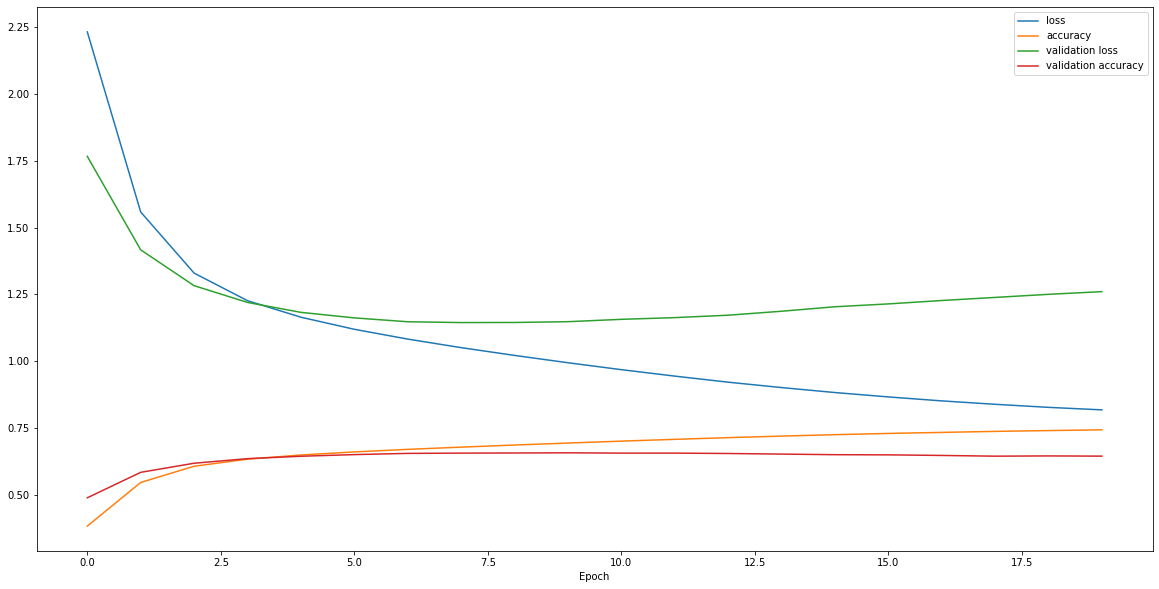

In [20]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist.history["loss"], label='loss')
ax.plot(hist.history["accuracy"], label='accuracy')
ax.plot(hist.history["val_loss"], label='validation loss')
ax.plot(hist.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [21]:
class OneStep(tf.keras.Model):
    def __init__(self, model, one_hot, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.one_hot = one_hot

    def generate_one_step(self, inputs, states=None):        
        input_encoded = one_hot.encode(inputs, dtype=np.uint16)
        input_encoded = input_encoded.reshape((1, *input_encoded.shape))
        

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        pred, states = self.model(inputs=input_encoded, states=states, return_state=True)
        
        # Convert from token ids to characters
        predicted_token = self.one_hot.decode(pred[0])
    
        # Return the characters and model state.
        return predicted_token[-1], states

In [22]:
def generate_text(initial_chars, amount_generation, one_step_model):
    initial_chars = tokenize(initial_chars)
    start = time.time()
    states = None
    next_char = initial_chars
    result = initial_chars

    for n in range(amount_generation):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)
        if (n+1) % 10000 == 0:
            print("Generation step", n+1, "/", amount_generation)

    end = time.time()
    return untokenize(result), end - start

In [23]:
one_step = OneStep(model, one_hot)

In [24]:
generated_book_title = "Harry Potter and the learned machine"
generated_book_len = 20_000
generated_book_first = "THE BOY WAKES UP\n\n".upper()

generated_text, t = generate_text(initial_chars=generated_book_first, amount_generation=generated_book_len, one_step_model=one_step)
print("-" * 25)
save_book(8, generated_book_title, generated_text)
print(generated_text[:1000])
print("-" * 25)
print("Run time:", timedelta(seconds=t))
print("-" * 25)

Generation step 10000 / 20000
Generation step 20000 / 20000
-------------------------
THE BOY WAKES UP




Harry Potter and the Goblet of Fire - J.K. Rowling 




“They were going to come and help your wand,” said 
Harry. “The power to repeat me and my prophecy in 
the country,” said Mrs. Weasley, starting to puls 
himself up and down the stairs as she strode back to 
the castle. 

“I think we should think of them,” said Harry, 
and he stood up and saw that it had been staring 
at him with a strange angry whole body and a large 
red spark in the corner came the biggest to the stars ... 

Harry was sure the rest of the class had been stuck in 
the fire. 

“I don’t want to stay here, Harry,” said Mrs. Weasley, 
pulling out his wand. “I think we should go and 
walk to a time of my parents, which is going to go 
and have a go at my mother and find him.” 

“But what do you think they’d be able to do it again? 

I don’t want to help you, Harry. ...” 

“You think you’re doing and a little boy

## x.5 Vergleich mit LSTM und GRU

TODO Einleitung schreiben.

**Ihre Aufgaben**

(1) TODO

## x.6 (Optional) Try it yourself

TODO Einleitung schreiben.

**Ihre Aufgaben**

(1) TODO

## Wusstest du? 
Mit dem Wissen aus dieser Vorlesungseinheit/Übung könntest du deine eigene Autovervollständigung programmieren. 

TODO Erklären wie das geht. Nützliche Links einstreuen.